In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [47]:
df=pd.read_csv('monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [48]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<AxesSubplot:xlabel='Date'>

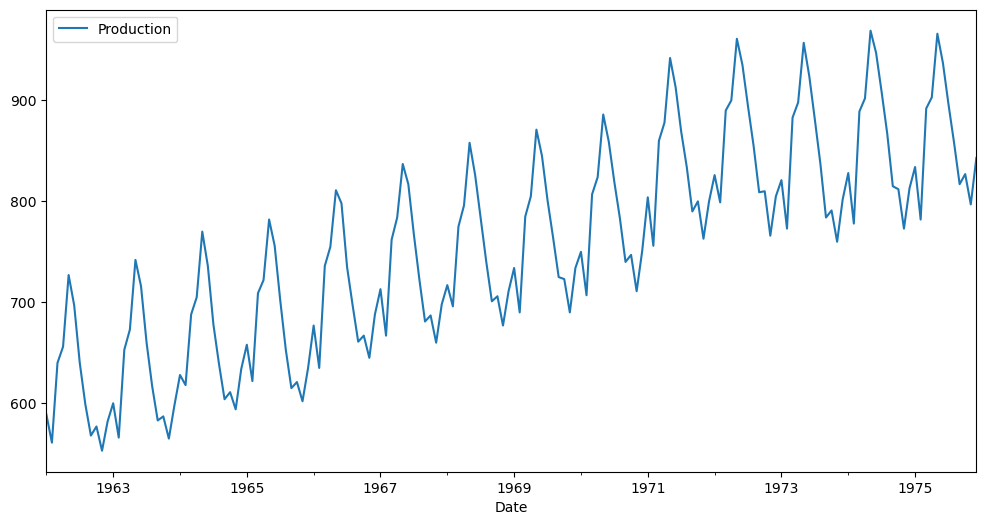

In [49]:
df.plot(figsize=(12,6))


In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose

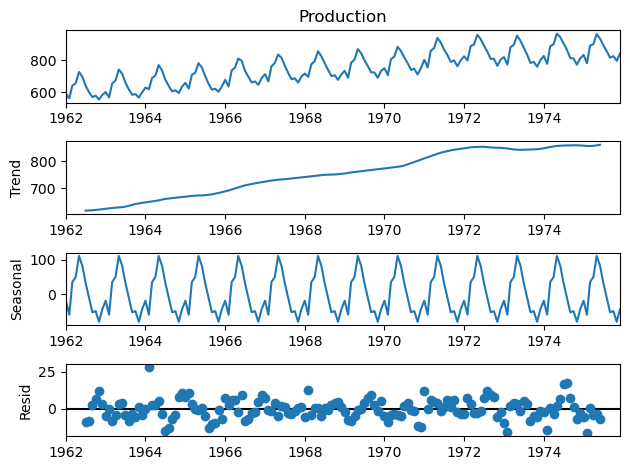

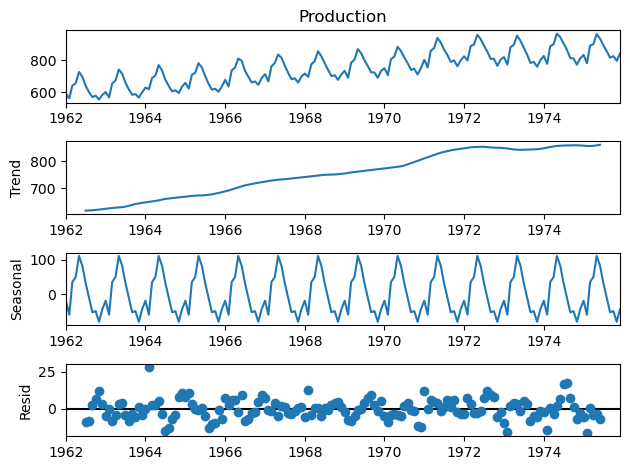

In [51]:
seasonal_decompose(df['Production']).plot()

In [52]:
#WE WILL USE LAST 12 MONTHS AS TESTING DATA

In [53]:
train=df.iloc[:(len(df)-12)]
test=df.iloc[(len(df)-12):]

In [54]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [55]:
#normalization

In [56]:
scaler.fit(train)
scaled_train=scaler.transform(train)
sclaed_test=scaler.transform(test)

In [57]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [58]:
sclaed_test[:10]

array([[0.67548077],
       [0.55048077],
       [0.81490385],
       [0.84134615],
       [0.99278846],
       [0.92307692],
       [0.82451923],
       [0.73317308],
       [0.63461538],
       [0.65865385]])

In [60]:
#we will make a lstm such that it intakes 12 months data and outputs 13th month data i.e. outputs the prediction for next month

In [61]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [62]:
n_input=12
n_features=1

generator=TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [63]:
x,y=generator[0]
print(f'Given the Array: \n{x.flatten()}')
print(f'Predict this y: \{y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462 0.24759615 0.41826923 0.34615385
 0.20913462 0.11057692 0.03605769 0.05769231 0.         0.06971154]
Predict this y: \[[0.11298077]]


In [64]:
x,y=generator[1]
print(f'Given the Array: \n{x.flatten()}')
print(f'Predict this y: \{y}')

Given the Array: 
[0.01923077 0.20913462 0.24759615 0.41826923 0.34615385 0.20913462
 0.11057692 0.03605769 0.05769231 0.         0.06971154 0.11298077]
Predict this y: \[[0.03125]]


In [65]:
x,y=generator[2]
print(f'Given the Array: \n{x.flatten()}')
print(f'Predict this y: \{y}')

Given the Array: 
[0.20913462 0.24759615 0.41826923 0.34615385 0.20913462 0.11057692
 0.03605769 0.05769231 0.         0.06971154 0.11298077 0.03125   ]
Predict this y: \[[0.24038462]]


In [66]:
x.shape

(1, 12, 1)

In [67]:
y.shape

(1, 1)

In [68]:
#model

In [69]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM




In [70]:
model=Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [71]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [72]:
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 4s 10ms/step - loss: 0.0443
Epoch 2/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0236
Epoch 3/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0183
Epoch 4/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0142
Epoch 5/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0118
Epoch 6/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0083
Epoch 7/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0073
Epoch 8/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0065
Epoch 9/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0054
Epoch 10/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0042
Epoch 11/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0035
Epoch 12/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0043
Epoch 13/50
144/144 [===

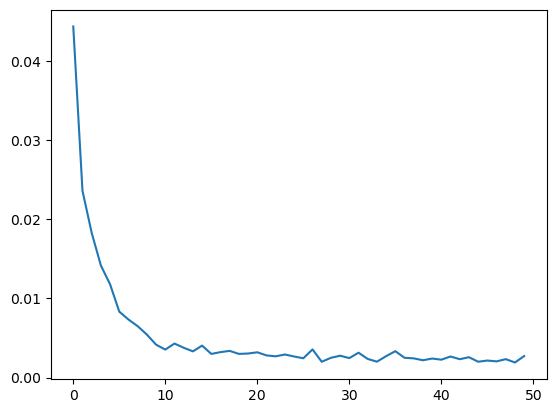

In [73]:
loss_per_epoch=model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [74]:
last_train_batch=scaled_train[-12:]

In [75]:
last_train_batch=last_train_batch.reshape((1,n_input,n_features))

In [76]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 290ms/step


array([[0.639405]], dtype=float32)

In [77]:
#now let us see the actua value
sclaed_test[0]

array([0.67548077])

In [78]:
#now let us make prediction for the entire test set
test_predictions=[]
first_eval_batch=scaled_train[-n_input:]
current_batch=first_eval_batch.reshape((1,n_input,n_features))

for i in range(len(test)):
    current_pred=model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 38ms/step


In [79]:
test_predictions

[array([0.639405], dtype=float32),
 array([0.5991486], dtype=float32),
 array([0.7788299], dtype=float32),
 array([0.8322373], dtype=float32),
 array([0.9372789], dtype=float32),
 array([0.9214743], dtype=float32),
 array([0.858299], dtype=float32),
 array([0.7701886], dtype=float32),
 array([0.6620858], dtype=float32),
 array([0.62441874], dtype=float32),
 array([0.5654095], dtype=float32),
 array([0.6053314], dtype=float32)]

In [80]:
true_predictions=scaler.inverse_transform(test_predictions)

In [81]:
test['Predictions']=true_predictions

C:\Users\arsha\AppData\Local\Temp\ipykernel_17236\2664784394.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions']=true_predictions


<AxesSubplot:xlabel='Date'>

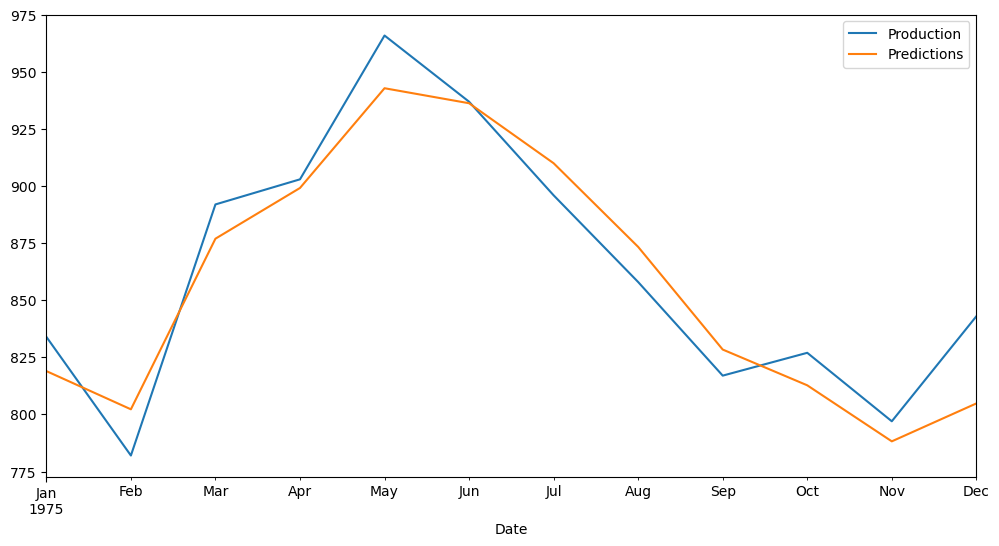

In [82]:
test.plot(figsize=(12,6))

In [83]:
##our prediction is close :)